In [1]:
import os
import argparse
import torch
import numpy as np
import pytorch_lightning as pl
from omegaconf import OmegaConf

from StructDiffusion.data.semantic_arrangement import SemanticArrangementDataset
from StructDiffusion.language.tokenizer import Tokenizer
from StructDiffusion.models.pl_models import ConditionalPoseDiffusionModel
from StructDiffusion.diffusion.sampler import Sampler
from StructDiffusion.diffusion.pose_conversion import get_struct_objs_poses
from StructDiffusion.utils.files import get_checkpoint_path_from_dir, replace_config_for_testing_data
from StructDiffusion.utils.batch_inference import move_pc_and_create_scene_simple, visualize_batch_pcs

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset = SemanticArrangementDataset(split="test", tokenizer=tokenizer, **cfg.DATASET)

NameError: name 'tokenizer' is not defined

In [1]:
import copy
import time
import torch
import numpy as np
import os
import argparse
from omegaconf import OmegaConf
from torch.utils.data import DataLoader

from structformer.data.tokenizer import Tokenizer
from structformer.evaluation.test_object_selection_network import ObjectSelectionInference
from structformer.evaluation.test_structformer import PriorInference
from structformer.utils.rearrangement import show_pcs_with_predictions, get_initial_scene_idxs, evaluate_target_object_predictions, save_img, show_pcs_with_labels, test_new_vis, show_pcs
from structformer.evaluation.inference import PointCloudRearrangement

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
import sys
import random
import pybullet as p
# point cloud utils
from pc_utils import depth2pc

# tabletop environment
FILE_PATH = '' #os.path.dirname(os.path.abspath(__file__))
sys.path.append(os.path.join(FILE_PATH, '../..', 'TabletopTidyingUp/pybullet_ur5_robotiq'))
from custom_env import TableTopTidyingUpEnv, get_contact_objects
from utilities import Camera, Camera_front_top
sys.path.append(os.path.join(FILE_PATH, '../..', 'TabletopTidyingUp'))
from collect_template_list import scene_list

In [7]:
def setupEnvironment(args=None):
    camera_top = Camera((0, 0, 1.45), 0.02, 2, (480, 360), 60)
    camera_front_top = Camera_front_top((0.5, 0, 1.3), 0.02, 2, (480, 360), 60)
    
    data_dir = '/ssd/disk' #args.data_dir
    objects_cfg = { 'paths': {
            'pybullet_object_path' : os.path.join(data_dir, 'pybullet-URDF-models/urdf_models/models'),
            'ycb_object_path' : os.path.join(data_dir, 'YCB_dataset'),
            'housecat_object_path' : os.path.join(data_dir, 'housecat6d/obj_models_small_size_final'),
        },
        'split' : 'inference' #args.object_split #'inference' #'train'
    }
    
    gui_on = False #not args.gui_off
    env = TableTopTidyingUpEnv(objects_cfg, camera_top, camera_front_top, vis=gui_on, gripper_type='85')
    p.resetDebugVisualizerCamera(2.0, -270., -60., (0., 0., 0.))
    p.configureDebugVisualizer(p.COV_ENABLE_SHADOWS, 1)  # Shadows on/off
    p.addUserDebugLine([0, -0.5, 0], [0, -0.5, 1.1], [0, 1, 0])

    env.reset()
    return env

In [12]:
env = setupEnvironment()

scenes = [s for s in sorted(list(scene_list.keys())) if s.startswith('D')]
selected_scene = random.choice(scenes)
print('Selected scene: %s' %selected_scene)

objects = scene_list[selected_scene]

sizes = []
for i in range(len(objects)):
    if 'small' in objects[i]:
        sizes.append('small')
        objects[i] = objects[i].replace('small_', '')
    elif 'large' in objects[i]:
        sizes.append('large')
        objects[i] = objects[i].replace('large_', '')
    else:
        sizes.append('medium')
objects = [[objects[i], sizes[i]] for i in range(len(objects))]
selected_objects = objects

env.spawn_objects(selected_objects)
env.arrange_objects(random=True)

(1.299038052558899, 0.0, 0.0, 0.0, 0.0, 1.7320507764816284, 0.0, 0.0, 0.0, 0.0, -1.0202020406723022, -1.0, 0.0, 0.0, -0.04040404036641121, 0.0)
[[ 0.          0.99999999  0.        ]
 [ 0.99999999 -0.          0.        ]
 [ 0.          0.         -1.        ]]
[[ 0.          0.89442719 -0.4472136 ]
 [ 1.         -0.          0.        ]
 [-0.         -0.4472136  -0.89442719]]
----------------------------------------
414 objects can be loaded.
----------------------------------------
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
ee_linkb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,467]:
Bad inertia tensor properties, setting inertia to zero for link: left_inner_finger_pad
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,467]:
Bad inertia tensor proper

True

In [114]:
#obs = env.reset()

env.spawn_objects(selected_objects)
env.arrange_objects(random=True)
obs = env.get_observation()

rgb = obs['top']['rgb']
depth = obs['top']['depth']
seg = obs['top']['segmentation']

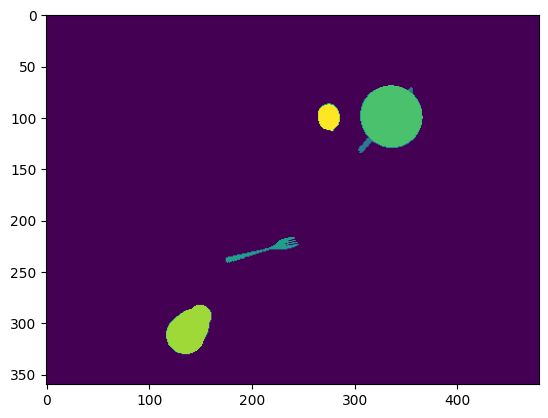

In [119]:
plt.imshow(seg)

In [120]:
seg

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [100]:
env.camera.rgbd_2_world

<bound method Camera.rgbd_2_world of <utilities.Camera object at 0x7f1264a5f880>>

In [94]:
env.camera.rgbd_2_world(rgb, depth)

../../TabletopTidyingUp/pybullet_ur5_robotiq/utilities.py:107: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(kwargs) is not 0:
../../TabletopTidyingUp/pybullet_ur5_robotiq/utilities.py:184: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(kwargs) is not 0:
../../TabletopTidyingUp/pybullet_ur5_robotiq/utilities.py:107: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(kwargs) is not 0:
../../TabletopTidyingUp/pybullet_ur5_robotiq/utilities.py:184: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(kwargs) is not 0:


IndexError: arrays used as indices must be of integer (or boolean) type

In [14]:
depth

array([[0.82500076, 0.82500076, 0.82500076, ..., 0.82500076, 0.82500076,
        0.82500076],
       [0.82500076, 0.82500076, 0.82500076, ..., 0.82500076, 0.82500076,
        0.82500076],
       [0.82500076, 0.82500076, 0.82500076, ..., 0.82500076, 0.82500076,
        0.82500076],
       ...,
       [0.82500076, 0.82500076, 0.82500076, ..., 0.82500076, 0.82500076,
        0.82500076],
       [0.82500076, 0.82500076, 0.82500076, ..., 0.82500076, 0.82500076,
        0.82500076],
       [0.82500076, 0.82500076, 0.82500076, ..., 0.82500076, 0.82500076,
        0.82500076]], dtype=float32)

In [123]:
env.urdf_id_names

{'pybullet-0': 'black_marker',
 'pybullet-1': 'bleach_cleanser',
 'pybullet-2': 'blue_cup',
 'pybullet-3': 'blue_marker',
 'pybullet-4': 'blue_moon',
 'pybullet-5': 'blue_plate',
 'pybullet-6': 'blue_tea_box',
 'pybullet-7': 'book_1',
 'pybullet-8': 'book_2',
 'pybullet-9': 'book_3',
 'pybullet-10': 'book_4',
 'pybullet-11': 'book_5',
 'pybullet-12': 'book_6',
 'pybullet-13': 'book_holder_1',
 'pybullet-14': 'book_holder_2',
 'pybullet-15': 'book_holder_3',
 'pybullet-16': 'bowl',
 'pybullet-17': 'cleanser',
 'pybullet-18': 'clear_box',
 'pybullet-19': 'clear_box_1',
 'pybullet-20': 'clear_box_2',
 'pybullet-21': 'conditioner',
 'pybullet-22': 'correction_fluid',
 'pybullet-23': 'cracker_box',
 'pybullet-24': 'doraemon_bowl',
 'pybullet-25': 'doraemon_plate',
 'pybullet-26': 'extra_large_clamp',
 'pybullet-27': 'flat_screwdriver',
 'pybullet-28': 'fork',
 'pybullet-29': 'gelatin_box',
 'pybullet-30': 'glue_1',
 'pybullet-31': 'glue_2',
 'pybullet-32': 'green_bowl',
 'pybullet-33': 'gre

In [122]:
env.pre_selected_objects

[4, 5, 6, 7, 8]

In [121]:
env.current_pybullet_ids

[4, 5, 6, 7, 8]

In [76]:
ids

{'object_00': 10,
 'object_01': 11,
 'object_02': 12,
 'object_03': 13,
 'object_04': 14,
 'object_05': 15,
 'robot': 0,
 'robot_hand': 1,
 'table': 2}

In [ ]:
rgb, depth -> xyz, depth
ids
valid
seg

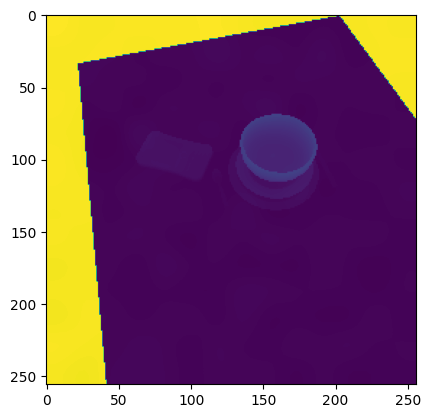

In [89]:
plt.imshow(xyz[:,:,2])

In [102]:
ids

{'object_00': 10,
 'object_01': 11,
 'object_02': 12,
 'object_03': 13,
 'object_04': 14,
 'object_05': 15,
 'robot': 0,
 'robot_hand': 1,
 'table': 2}

In [149]:
env.table_objects_list

{4: ('inference-knife_3_new', 'medium'),
 5: ('inference-fork_3_new', 'medium'),
 6: ('inference_round_plate_4', 'medium'),
 7: ('glass-new_1', 'medium'),
 8: ('plastic_lemon', 'medium')}

In [139]:
goal_specification["shape"]

{'length': 0.2631578947368421,
 'length_increment': 0.05,
 'max_length': 1.0,
 'min_length': 0.0,
 'place_at_once': 'True',
 'position': [0.4856287214206586, 0.0, 0.0],
 'rotation': [0.0, -0.0, 0.0],
 'type': 'dinner',
 'uniform_space': 'False'}

In [140]:
object_selection_structured_sentence

[('dinner', 'scene'), ('PAD',), ('PAD',), ('PAD',)]

In [148]:
goal_specification["shape"]

{'length': 0.2631578947368421,
 'length_increment': 0.05,
 'max_length': 1.0,
 'min_length': 0.0,
 'place_at_once': 'True',
 'position': [0.4856287214206586, 0.0, 0.0],
 'rotation': [0.0, -0.0, 0.0],
 'type': 'dinner',
 'uniform_space': 'False'}

In [147]:
goal_specification["anchor"]a

{'combine_features_logic': None, 'features': [], 'objects': []}

In [141]:
structure_specification_structured_sentence

[('dinner', 'shape'),
 (0.0, 'rotation'),
 (0.4856287214206586, 'position_x'),
 (0.0, 'position_y'),
 ('PAD',)]

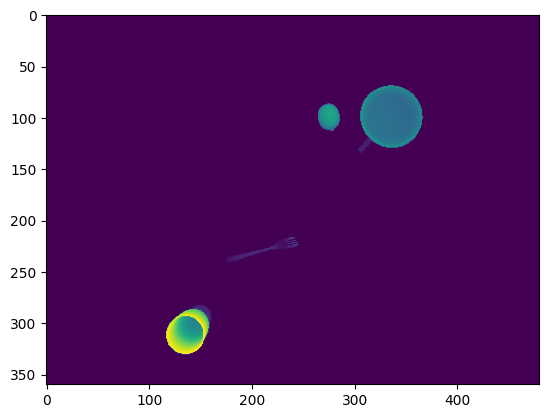

In [137]:
x = env.camera.rgbd_2_world_batch(depth)
plt.imshow(x[:, :, 2])

In [126]:
ids

{'object_00': 10,
 'object_01': 11,
 'object_02': 12,
 'object_03': 13,
 'object_04': 14,
 'object_05': 15,
 'robot': 0,
 'robot_hand': 1,
 'table': 2}

In [101]:
goal_specification

{'anchor': {'combine_features_logic': None, 'features': [], 'objects': []},
 'distract': {'combine_features_logic': None,
  'features': [],
  'objects': [{'T': [[1.0, 0.0, 0.0, 0.0],
     [0.0, 1.0, 0.0, 0.0],
     [0.0, 0.0, 1.0, 0.0],
     [0.0, 0.0, 0.0, 1.0]],
    'bounds': [[-0.0842859174488549,
      -0.052987181238162734,
      -0.010125873808070363],
     [0.08888320883414517, 0.052424731990690435, 0.011992443039294217]],
    'class': 'CellPhone',
    'color': 'yellow',
    'height': 0.02211831684736458,
    'mass': 1.2440213912705291,
    'material': 'plastic',
    'shapenet_id': 'eb42218d2a584af6259592a4a580c1e4',
    'size': 'S',
    'urdf': 'CellPhone_eb42218d2a584af6259592a4a580c1e4_S.urdf',
    'volumn': 0.00040374972235229523}]},
 'order': {'feature': None},
 'random_selection': {'nonvarying_features': [], 'varying_features': []},
 'rearrange': {'combine_features_logic': None,
  'count': None,
  'features': [{'comparator': None, 'type': 'scene', 'value': 'dinner'}],
  'o

In [189]:
filename, t = '/home/gun/ssd/disk/StructFormer/data_new_objects_test_split/examples_dinner_new_objects/result/batch_50000_62000/leonardo/data00050717.h5', 0
#filename, t = self.arrangement_data[idx]
filename, t = object_selection_inference.dataset.arrangement_data[100]

def _get_ids(h5):
    """
    get object ids

    @param h5:
    @return:
    """
    ids = {}
    for k in h5.keys():
        if k.startswith("id_"):
            ids[k[3:]] = h5[k][()]
    return ids

h5 = h5py.File(filename, 'r')
ids = _get_ids(h5)
# moved_objs = h5['moved_objs'][()].split(',')
all_objs = sorted([o for o in ids.keys() if "object_" in o])
goal_specification = json.loads(str(np.array(h5["goal_specification"]).astype(str)))
num_rearrange_objs = len(goal_specification["rearrange"]["objects"])
# all_object_specs = goal_specification["rearrange"]["objects"] + goal_specification["anchor"]["objects"] + \
#                    goal_specification["distract"]["objects"]

###################################
# getting scene images and point clouds
scene = object_selection_inference.dataset._get_images(h5, t, ee=True)
rgb, depth, seg, valid, xyz = scene

In [4]:
np.random.choice(5)

1

In [190]:
pprint(goal_specification['shape'])

{'length': 0.3684210526315789,
 'length_increment': 0.05,
 'max_length': 1.0,
 'min_length': 0.0,
 'place_at_once': 'True',
 'position': [0.682190525236573, 0.0, 0.0],
 'rotation': [0.0, -0.0, 0.0],
 'type': 'dinner',
 'uniform_space': 'False'}


In [162]:
init_datum['rearrange_obj_labels']

[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, -100.0, -100.0, -100.0, -100.0, -100.0]

In [163]:
init_datum["object_pad_mask"]

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

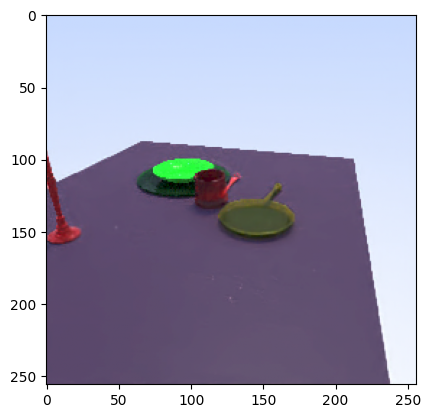

In [156]:
plt.imshow(rgb)

In [25]:
os.environ["DATETIME"] = time.strftime("%Y%m%d-%H%M%S")

dataset_base_dir = '/home/gun/ssd/disk/StructFormer/data_new_objects_test_split'
object_selection_model_dir = '/home/gun/Desktop/StructFormer/models/object_selection_network/best_model'
pose_generation_model_dir = '/home/gun/Desktop/StructFormer/models/structformer_dinner/best_model'
dirs_config = '/home/gun/Desktop/StructFormer/configs/data/dinner_dirs.yaml'

dirs_cfg = OmegaConf.load(dirs_config)
dirs_cfg.dataset_base_dir = dataset_base_dir
OmegaConf.resolve(dirs_cfg)

# load models
object_selection_inference = ObjectSelectionInference(object_selection_model_dir, dirs_cfg)
pose_generation_inference = PriorInference(pose_generation_model_dir, dirs_cfg)

test_dataset = object_selection_inference.dataset
initial_scene_idxs = get_initial_scene_idxs(test_dataset)

idx = 0
#for idx in range(len(test_dataset)):
#    if idx not in initial_scene_idxs:
#        continue
#    if idx == 4:
#        continue

filename, _ = test_dataset.get_data_index(idx)
scene_id = os.path.split(filename)[1][4:-3]
print("-"*50)
print("Scene No.{}".format(scene_id))

# retrieve data
init_datum = test_dataset.get_raw_data(idx)
goal_specification = init_datum["goal_specification"]
object_selection_structured_sentence = init_datum["sentence"][5:]
structure_specification_structured_sentence = init_datum["sentence"][:5]
object_selection_natural_sentence = object_selection_inference.tokenizer.convert_to_natural_sentence(object_selection_structured_sentence)
structure_specification_natural_sentence = object_selection_inference.tokenizer.convert_structure_params_to_natural_language(structure_specification_structured_sentence)


Build one vacab for everything...
The vocab has 124 tokens: {'PAD': 0, 'CLS': 1, 'class:MASK': 2, 'class:Basket': 3, 'class:BeerBottle': 4, 'class:Book': 5, 'class:Bottle': 6, 'class:Bowl': 7, 'class:Calculator': 8, 'class:Candle': 9, 'class:CellPhone': 10, 'class:ComputerMouse': 11, 'class:Controller': 12, 'class:Cup': 13, 'class:Donut': 14, 'class:Fork': 15, 'class:Hammer': 16, 'class:Knife': 17, 'class:Marker': 18, 'class:MilkCarton': 19, 'class:Mug': 20, 'class:Pan': 21, 'class:Pen': 22, 'class:PillBottle': 23, 'class:Plate': 24, 'class:PowerStrip': 25, 'class:Scissors': 26, 'class:SoapBottle': 27, 'class:SodaCan': 28, 'class:Spoon': 29, 'class:Stapler': 30, 'class:Teapot': 31, 'class:VideoGameController': 32, 'class:WineBottle': 33, 'class:CanOpener': 34, 'class:Fruit': 35, 'scene:MASK': 36, 'scene:dinner': 37, 'size:MASK': 38, 'size:L': 39, 'size:M': 40, 'size:S': 41, 'color:MASK': 42, 'color:blue': 43, 'color:cyan': 44, 'color:green': 45, 'color:magenta': 46, 'color:red': 47, '

data dirs: ['/home/gun/ssd/disk/StructFormer/data_new_objects_test_split/examples_dinner_new_objects/result']

Build one vacab for everything...
The vocab has 124 tokens: {'PAD': 0, 'CLS': 1, 'class:MASK': 2, 'class:Basket': 3, 'class:BeerBottle': 4, 'class:Book': 5, 'class:Bottle': 6, 'class:Bowl': 7, 'class:Calculator': 8, 'class:Candle': 9, 'class:CellPhone': 10, 'class:ComputerMouse': 11, 'class:Controller': 12, 'class:Cup': 13, 'class:Donut': 14, 'class:Fork': 15, 'class:Hammer': 16, 'class:Knife': 17, 'class:Marker': 18, 'class:MilkCarton': 19, 'class:Mug': 20, 'class:Pan': 21, 'class:Pen': 22, 'class:PillBottle': 23, 'class:Plate': 24, 'class:PowerStrip': 25, 'class:Scissors': 26, 'class:SoapBottle': 27, 'class:SodaCan': 28, 'class:Spoon': 29, 'class:Stapler': 30, 'class:Teapot': 31, 'class:VideoGameController': 32, 'class:WineBottle': 33, 'class:CanOpener': 34, 'class:Fruit': 35, 'scene:MASK': 36, 'scene:dinner': 37, 'size:MASK': 38, 'size:L': 39, 'size:M': 40, 'size:S': 41, 'c

data dirs: ['/home/gun/ssd/disk/StructFormer/data_new_objects_test_split/examples_dinner_new_objects/result']
2440 valid sequences
--------------------------------------------------
Scene No.00021115


In [29]:
len(all_obj_xyzs)

6

In [30]:
all_obj_xyzs[0].shape

torch.Size([1024, 3])

In [31]:
all_obj_xyzs[1].shape

torch.Size([1024, 3])

In [32]:
all_obj_rgbs[0].shape

torch.Size([1024, 3])

In [58]:
object_selection_inference.dataset.arrangement_data[0]

('/home/gun/ssd/disk/StructFormer/data_new_objects_test_split/examples_dinner_new_objects/result/batch_10000_33000/leonardo/data00021115.h5',
 0)

In [57]:
object_selection_inference.dataset.get_raw_data(0)

{'xyzs': [tensor([[0.5348, 0.1938, 0.0538],
          [0.5874, 0.2406, 0.0525],
          [0.5787, 0.2254, 0.0522],
          ...,
          [0.5917, 0.2707, 0.0529],
          [0.6373, 0.2487, 0.0544],
          [0.5500, 0.2612, 0.0536]]),
  tensor([[ 0.3997, -0.1130,  0.0378],
          [ 0.4838, -0.1150,  0.0378],
          [ 0.4006, -0.1099,  0.0378],
          ...,
          [ 0.4415, -0.1108,  0.0381],
          [ 0.4611, -0.1160,  0.0384],
          [ 0.4406, -0.1140,  0.0381]]),
  tensor([[0.4645, 0.1376, 0.0378],
          [0.4736, 0.1387, 0.0366],
          [0.5048, 0.1333, 0.0421],
          ...,
          [0.4335, 0.1392, 0.0386],
          [0.4866, 0.1453, 0.0380],
          [0.4335, 0.1392, 0.0386]]),
  tensor([[ 0.4181,  0.0703,  0.0430],
          [ 0.4086,  0.0634,  0.0432],
          [ 0.4317,  0.0897,  0.0488],
          ...,
          [ 0.3915,  0.0263,  0.0430],
          [ 0.3795, -0.0182,  0.0485],
          [ 0.3809,  0.0540,  0.0486]]),
  tensor([[ 0.4851, -0.0

In [50]:
import h5py
import json

In [55]:
h5.keys()

<KeysViewHDF5 ['action', 'base_pose', 'cam_far', 'cam_fov', 'cam_height', 'cam_near', 'cam_pose', 'cam_width', 'camera_view', 'depth', 'depth_max', 'depth_min', 'ee_cam_pose', 'ee_camera_view', 'ee_depth', 'ee_depth_max', 'ee_depth_min', 'ee_pose', 'ee_rgb', 'ee_seg', 'goal_specification', 'gripper', 'id_object_00', 'id_object_01', 'id_object_02', 'id_object_03', 'id_object_04', 'id_robot', 'id_robot_hand', 'id_table', 'logical', 'moved_objs', 'object_00', 'object_01', 'object_02', 'object_03', 'object_04', 'predicate_idx_above(object_00, object_01)', 'predicate_idx_above(object_00, object_02)', 'predicate_idx_above(object_00, object_03)', 'predicate_idx_above(object_00, object_04)', 'predicate_idx_above(object_00, robot)', 'predicate_idx_above(object_01, object_00)', 'predicate_idx_above(object_01, object_02)', 'predicate_idx_above(object_01, object_03)', 'predicate_idx_above(object_01, object_04)', 'predicate_idx_above(object_01, robot)', 'predicate_idx_above(object_02, object_00)', 

In [60]:
np.array(h5["goal_specification"])

array(b'{"anchor": {"combine_features_logic": null, "features": [], "objects": []}, "distract": {"combine_features_logic": null, "features": [], "objects": [{"T": [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]], "bounds": [[-0.0842859174488549, -0.052987181238162734, -0.010125873808070363], [0.08888320883414517, 0.052424731990690435, 0.011992443039294217]], "class": "CellPhone", "color": "yellow", "height": 0.02211831684736458, "mass": 1.2440213912705291, "material": "plastic", "shapenet_id": "eb42218d2a584af6259592a4a580c1e4", "size": "S", "urdf": "CellPhone_eb42218d2a584af6259592a4a580c1e4_S.urdf", "volumn": 0.00040374972235229523}]}, "order": {"feature": null}, "random_selection": {"nonvarying_features": [], "varying_features": []}, "rearrange": {"combine_features_logic": null, "count": null, "features": [{"comparator": null, "type": "scene", "value": "dinner"}], "objects": [{"T": [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0

In [76]:
ids

{'object_00': 10,
 'object_01': 11,
 'object_02': 12,
 'object_03': 13,
 'object_04': 14,
 'object_05': 15,
 'robot': 0,
 'robot_hand': 1,
 'table': 2}

In [ ]:
rgb, depth -> xyz, depth
ids
valid
seg

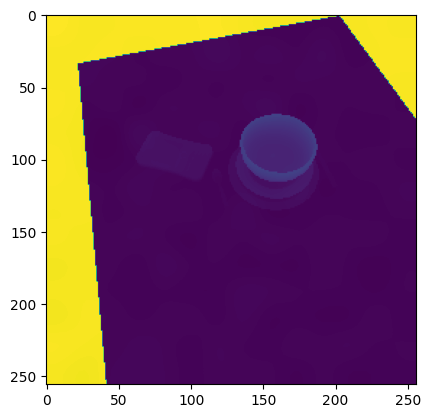

In [89]:
plt.imshow(xyz[:,:,2])

In [62]:
filename, t = '/home/gun/ssd/disk/StructFormer/data_new_objects_test_split/examples_dinner_new_objects/result/batch_50000_62000/leonardo/data00050717.h5', 0
#filename, t = self.arrangement_data[idx]
filename, t = object_selection_inference.dataset.arrangement_data[0]

def _get_ids(h5):
    """
    get object ids

    @param h5:
    @return:
    """
    ids = {}
    for k in h5.keys():
        if k.startswith("id_"):
            ids[k[3:]] = h5[k][()]
    return ids

h5 = h5py.File(filename, 'r')
ids = _get_ids(h5)
# moved_objs = h5['moved_objs'][()].split(',')
all_objs = sorted([o for o in ids.keys() if "object_" in o])
goal_specification = json.loads(str(np.array(h5["goal_specification"]).astype(str)))
num_rearrange_objs = len(goal_specification["rearrange"]["objects"])
# all_object_specs = goal_specification["rearrange"]["objects"] + goal_specification["anchor"]["objects"] + \
#                    goal_specification["distract"]["objects"]

###################################
# getting scene images and point clouds
scene = object_selection_inference.dataset._get_images(h5, t, ee=True)
rgb, depth, seg, valid, xyz = scene

In [65]:
from matplotlib import pyplot as plt

In [71]:
set(seg.reshape(-1).tolist())

{2, 10, 11, 12, 13, 14, 15, 255}

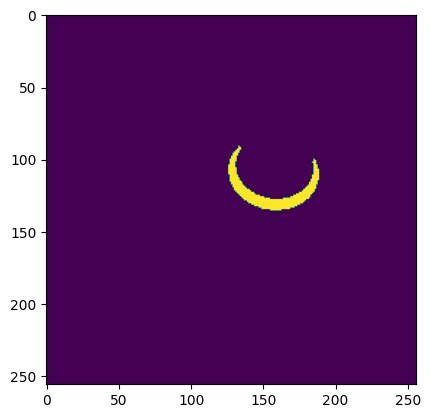

In [74]:
plt.imshow(seg==11)

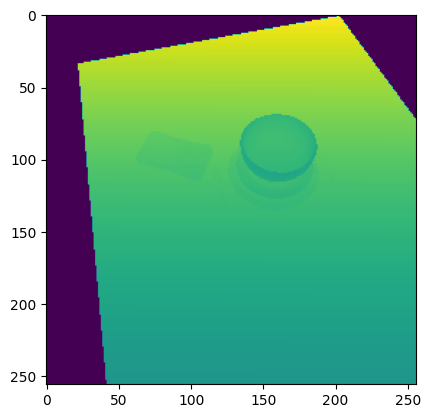

In [66]:
plt.imshow(depth)

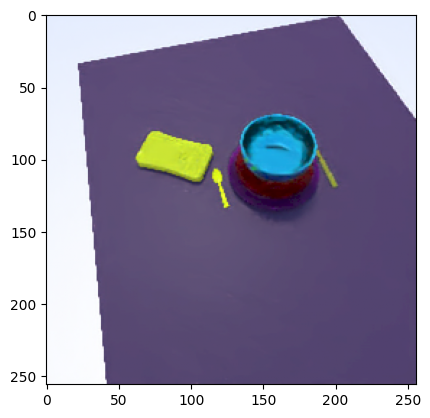

In [67]:
plt.imshow(rgb)

In [27]:
# object selection
predictions, gts = object_selection_inference.predict_target_objects(init_datum)

all_obj_xyzs = init_datum["xyzs"][:len(predictions)]
all_obj_rgbs = init_datum["rgbs"][:len(predictions)]
obj_idxs = [i for i, l in enumerate(predictions) if l == 1.0]
if len(obj_idxs) == 0:
    print('zero obj_idxs')
other_obj_idxs = [i for i, l in enumerate(predictions) if l == 0.0]
obj_xyzs = [all_obj_xyzs[i] for i in obj_idxs]
obj_rgbs = [all_obj_rgbs[i] for i in obj_idxs]
other_obj_xyzs = [all_obj_xyzs[i] for i in other_obj_idxs]
other_obj_rgbs = [all_obj_rgbs[i] for i in other_obj_idxs]

print("\nSelect objects to rearrange...")
print("Instruction:", object_selection_natural_sentence)
print("Visualize groundtruth (dot color) and prediction (ring color)")
show_pcs_with_predictions(init_datum["xyzs"][:len(predictions)], init_datum["rgbs"][:len(predictions)],
                          gts, predictions, add_table=True, side_view=True)
print("Visualize object to rearrange")
show_pcs(obj_xyzs, obj_rgbs, side_view=True, add_table=True)


Select objects to rearrange...
Instruction: select objects that are dinner.
Visualize groundtruth (dot color) and prediction (ring color)
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW


AttributeError: 'NoneType' object has no attribute 'set_front'

In [ ]:
# pose generation
max_num_objects = pose_generation_inference.cfg.dataset.max_num_objects
max_num_other_objects = pose_generation_inference.cfg.dataset.max_num_other_objects
if len(obj_xyzs) > max_num_objects:
    print("WARNING: reducing the number of \"query\" objects because this model is trained with a maximum of {} \"query\" objects. Train a new model if a larger number is needed.".format(max_num_objects))
    obj_xyzs = obj_xyzs[:max_num_objects]
    obj_rgbs = obj_rgbs[:max_num_objects]
if len(other_obj_xyzs) > max_num_other_objects:
    print("WARNING: reducing the number of \"distractor\" objects because this model is trained with a maximum of {} \"distractor\" objects. Train a new model if a larger number is needed.".format(max_num_other_objects))
    other_obj_xyzs = other_obj_xyzs[:max_num_other_objects]
    other_obj_rgbs = other_obj_rgbs[:max_num_other_objects]

pose_generation_datum = pose_generation_inference.dataset.prepare_test_data(obj_xyzs, obj_rgbs,
                                                                            other_obj_xyzs, other_obj_rgbs,
                                                                            goal_specification["shape"])
beam_data = []
beam_pc_rearrangements = []
for b in range(beam_size):
    datum_copy = copy.deepcopy(pose_generation_datum)
    beam_data.append(datum_copy)
    beam_pc_rearrangements.append(PointCloudRearrangement(datum_copy))

# autoregressive decoding
num_target_objects = beam_pc_rearrangements[0].num_target_objects

# first predict structure pose
beam_goal_struct_pose, target_object_preds = pose_generation_inference.limited_batch_inference(beam_data)
for b in range(beam_size):
    datum = beam_data[b]
    datum["struct_x_inputs"] = [beam_goal_struct_pose[b][0]]
    datum["struct_y_inputs"] = [beam_goal_struct_pose[b][1]]
    datum["struct_z_inputs"] = [beam_goal_struct_pose[b][2]]
    datum["struct_theta_inputs"] = [beam_goal_struct_pose[b][3:]]

# then iteratively predict pose of each object
beam_goal_obj_poses = []
for obj_idx in range(num_target_objects):
    struct_preds, target_object_preds = pose_generation_inference.limited_batch_inference(beam_data)
    beam_goal_obj_poses.append(target_object_preds[:, obj_idx])
    for b in range(beam_size):
        datum = beam_data[b]
        datum["obj_x_inputs"][obj_idx] = target_object_preds[b][obj_idx][0]
        datum["obj_y_inputs"][obj_idx] = target_object_preds[b][obj_idx][1]
        datum["obj_z_inputs"][obj_idx] = target_object_preds[b][obj_idx][2]
        datum["obj_theta_inputs"][obj_idx] = target_object_preds[b][obj_idx][3:]
# concat in the object dim
beam_goal_obj_poses = np.stack(beam_goal_obj_poses, axis=0)
# swap axis
beam_goal_obj_poses = np.swapaxes(beam_goal_obj_poses, 1, 0)  # batch size, number of target objects, pose dim

# move pc
for bi in range(beam_size):
    beam_pc_rearrangements[bi].set_goal_poses(beam_goal_struct_pose[bi], beam_goal_obj_poses[bi])
    beam_pc_rearrangements[bi].rearrange()

print("\nRearrange \"query\" objects...")
print("Instruction:", structure_specification_natural_sentence)
for pi, pc_rearrangement in enumerate(beam_pc_rearrangements):
    print("Visualize rearranged scene sample {}".format(pi))
    pc_rearrangement.visualize("goal", add_other_objects=True, add_table=True, side_view=True)